# 公募基金重仓股与持股变动分析

公募基金是市场中一大类的投资者群体，从公募基金的季度持股变动情况可以分析公募基金这类投资者对行业和公司未来方向的判断

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from WindPy import w
import datetime
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 连接聚源数据库

In [3]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=10.0.185.138;DATABASE=JYDB;UID=js_dev;PWD=js_dev')

# 查询所有公募基金的季度持仓表

In [4]:
query = 'SELECT fdo.InvestAdvisorAbbrName, t.SecuAbbr, s.SecuCode, s.SecuAbbr, f.ReportDate, f.SharesHolding, f.MarketValue \
FROM MF_KeyStockPortfolio as f, SecuMain as t, SecuMain as s, MF_FundArchives as fd, MF_InvestAdvisorOutline as fdo \
WHERE f.InnerCode = t.InnerCode \
    AND f.StockInnerCode = s.InnerCode \
    AND fd.InnerCode = f.InnerCode \
    AND fd.InvestAdvisorCode = fdo.InvestAdvisorCode \
    ORDER BY f.ReportDate DESC, f.SharesHolding DESC'

In [11]:
df = pd.read_sql_query(query, con=conn)

In [12]:
df.head()

,InvestAdvisorAbbrName,SecuAbbr,SecuCode,SecuAbbr,ReportDate,SharesHolding,MarketValue
0,平安大华,平安A股ETF,601398,工商银行,2018-07-13,769000.0,4121840.0
1,平安大华,平安A股ETF,600000,浦发银行,2018-07-13,418500.0,3971565.0
2,平安大华,平安A股ETF,601166,兴业银行,2018-07-13,296200.0,4256394.0
3,平安大华,平安A股ETF,600036,招商银行,2018-07-13,294800.0,7732604.0
4,平安大华,平安A股ETF,601318,中国平安,2018-07-13,154800.0,9061992.0


In [13]:
df.columns = ['InvestAdvisorAbbrName', 'FundAbbr', 'SecuCode', 'SecuAbbr', 'ReportDate', 'SharesHolding', 'MarketValue']

# 按时间、股票分组后相同的相加

In [14]:
df = df.groupby(['ReportDate', 'SecuAbbr', 'SecuCode']).sum()

In [15]:
df.head()

SharesHolding   MarketValue
ReportDate SecuAbbr SecuCode                             
1998-06-30 *ST 上普   600680        7896835.0  1.582526e+08
           上汽集团     600104        6172070.0  8.640900e+07
           上海机场     600009       17532150.0  1.779513e+08
           云赛智联     600602       14347258.0  1.338599e+08
           华东电脑     600850        5957804.0  1.145686e+08

# 剔除季报外的其他数据

In [16]:
df = df.reset_index(level=[1]).reset_index(level=[1])

In [17]:
df['Month'] = df.index.map(lambda x: x.month)
df['Day'] = df.index.map(lambda x: x.day)

In [18]:
df = df[(df['Month'].isin([3,6,9,12])) & (df['Day'].isin([30,31]))]

In [19]:
df.head()

,SecuCode,SecuAbbr,SharesHolding,MarketValue,Month,Day
ReportDate,,,,,,
1998-06-30,600680,*ST 上普,7896835.0,1.582526e+08,6,30
1998-06-30,600104,上汽集团,6172070.0,8.640900e+07,6,30
1998-06-30,600009,上海机场,17532150.0,1.779513e+08,6,30
1998-06-30,600602,云赛智联,14347258.0,1.338599e+08,6,30
1998-06-30,600850,华东电脑,5957804.0,1.145686e+08,6,30


# 计算每个季度的持仓变动

In [20]:
df['ReportDate'] = df.index

In [21]:
dates = df.index.drop_duplicates().sort_values(ascending=False).values

In [22]:
for next_date, prev_date in zip(dates, dates[1:]):
    next_date_hold = df[df.index == next_date]['SecuAbbr']
    prev_date_hold = df[df.index == prev_date]['SecuAbbr']
    codes = prev_date_hold.loc[~prev_date_hold.isin(next_date_hold)].values
    add_df = df[df['SecuAbbr'].isin(codes)].copy()
    add_df = add_df[add_df.index == prev_date]
    add_df['MarketValue'] = 0
    add_df['ReportDate'] = next_date
    df = df.append(add_df)

In [23]:
df = df.sort_values('ReportDate', ascending=False)

In [25]:
df['Diff'] = df['MarketValue'] - df.groupby('SecuAbbr')['MarketValue'].shift(-1)

In [26]:
df['Diff'] = df['Diff'].fillna(df['MarketValue'])

In [28]:
df = df.sort_values(['ReportDate', 'Diff'], ascending=False)

In [29]:
df = df.set_index('ReportDate')

In [34]:
df = df.drop(['Month', 'Day'], axis=1)

In [35]:
df.head()

,SecuCode,SecuAbbr,SharesHolding,MarketValue,Diff
ReportDate,,,,,
2018-06-30,600519,贵州茅台,48009872.0,3.511634e+10,4.435974e+09
2018-06-30,600276,恒瑞医药,168893690.0,1.279539e+10,4.016211e+09
2018-06-30,603589,口 子 窖,77404706.0,4.756519e+09,3.001166e+09
2018-06-30,000661,长春高新,35912845.0,8.177355e+09,2.517438e+09
2018-06-30,300601,康泰生物,59358383.0,3.680627e+09,2.412283e+09


In [36]:
df.tail()

,SecuCode,SecuAbbr,SharesHolding,MarketValue,Diff
ReportDate,,,,,
1998-06-30,600075,新疆天业,1773498.0,32774248.50,32774248.50
1998-06-30,000001,平安银行,1896697.0,32699063.04,32699063.04
1998-06-30,000623,吉林敖东,1698815.0,29559386.80,29559386.80
1998-06-30,600060,海信电器,1364498.0,25707157.94,25707157.94
1998-06-30,000021,深 科 技,908286.0,24596400.20,24596400.20


# 公募基金季度持股总数量变化

In [38]:
diff = df.groupby(df.index).sum()

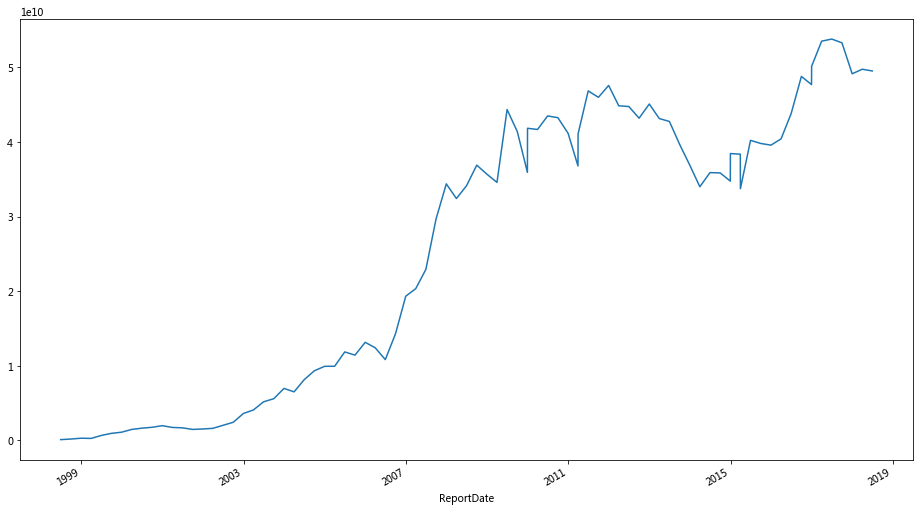

In [43]:
diff['SharesHolding'].plot(figsize=(16, 9))